**Combine Spectra**

In [10]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat

def combine_spectra(w1, I1, w2, I2,
                   overlap_low=900,
                   overlap_high=1100,
                   grid_step=5):

    # Interpolate wavelengths on a common grid
    wl_min = min(w1.min(), w2.min())
    wl_max = max(w1.max(), w2.max())
    wl = np.arange(wl_min, wl_max, grid_step)

    I1g = np.interp(wl, w1, I1, left=np.nan, right=np.nan)
    I2g = np.interp(wl, w2, I2, left=np.nan, right=np.nan)

    # Determine overlap region
    overlap = (wl >= overlap_low) & (wl <= overlap_high)
    I1o = I1g[overlap]
    I2o = I2g[overlap]

    valid = np.isfinite(I1o) & np.isfinite(I2o)

    # Multiply scale factor to overlap spectra
    x = I2o[valid]
    y = I1o[valid]
    scale = (x * y).sum() / (x * x).sum()

    I2g_scaled = scale * I2g

    # Combine spectra
    combined = np.zeros_like(wl) * np.nan

    # Outside overlap
    combined[wl < overlap_low] = I1g[wl < overlap_low]
    combined[wl > overlap_high] = I2g_scaled[wl > overlap_high]

    # Cosine blend in overlap to ensure gradual transition
    t = (wl[overlap] - overlap_low) / (overlap_high - overlap_low)
    w1w = 0.5 * (1 + np.cos(np.pi * t))
    w2w = 1 - w1w

    combined[overlap] = w1w * I1g[overlap] + w2w * I2g_scaled[overlap]

    return wl, combined, scale


# Input and output folders
folder_zeiss = r"K:\ALL\coen\exp1\zeiss"
folder_dlp   = r"K:\ALL\coen\exp1\dlp"
folder_out   = r"K:\ALL\coen\exp1\test\combined"

os.makedirs(folder_out, exist_ok=True)

# Load reference and dark spectra for calculating the reflectance
ref_z  = loadmat(os.path.join(folder_zeiss, "ref.mat"))['data'][0][0][0][0]
dark_z = loadmat(os.path.join(folder_zeiss, "dark.mat"))['data'][0][0][0][0]

ref_dlp  = pd.read_csv(os.path.join(folder_dlp, "ref.csv"),  header=21)
dark_dlp = pd.read_csv(os.path.join(folder_dlp, "dark.csv"), header=21)

# Zeiss wavelength axis
w1 = pd.read_csv(os.path.join(folder_zeiss, "zeiss_wavelengths.csv"))
w1 = w1.columns.to_numpy().astype(float)


zeiss_files = [f for f in os.listdir(folder_zeiss) if f.endswith(".mat")]
dlp_files   = [f for f in os.listdir(folder_dlp)   if f.endswith(".csv")]

pairs = [(zf, zf.replace(".mat", ".csv")) for zf in zeiss_files if zf.replace(".mat", ".csv") in dlp_files]

print("Found pairs:", pairs)

# Loop through samples
for zeiss_file, dlp_file in pairs:

    print("\nProcessing:", zeiss_file, "<->", dlp_file)

    # Load Zeiss sample and calculate reflectance
    zdat = loadmat(os.path.join(folder_zeiss, zeiss_file))
    sample_z = zdat['data'][0][0][0][0]
    I1 = (sample_z - dark_z) / (ref_z - dark_z)

    # Load DLP sample and calculate reflectance
    dlp = pd.read_csv(os.path.join(folder_dlp, dlp_file), header=21)

    sample2 = dlp["Sample Signal (unitless)"]
    r2      = ref_dlp["Sample Signal (unitless)"]
    d2      = dark_dlp["Sample Signal (unitless)"]

    I2 = (sample2 - d2) / (r2 - d2)
    I2 = I2.to_numpy()

    w2 = dlp["Wavelength (nm)"].to_numpy()
    
    wl, combined, scale = combine_spectra(w1, I1, w2, I2)

    print("  scale factor:", scale)

    out_df = pd.DataFrame({"wavelength_nm": wl, "reflectance": combined})
    out_file = os.path.join(folder_out, zeiss_file.replace(".mat", "_combined.csv"))
    out_df.to_csv(out_file, index=False)

    print("  saved:", out_file)

Found pairs: [('container1.mat', 'container1.csv'), ('container10.mat', 'container10.csv'), ('container2.mat', 'container2.csv'), ('container3.mat', 'container3.csv'), ('container4.mat', 'container4.csv'), ('container5.mat', 'container5.csv'), ('container6.mat', 'container6.csv'), ('container7.mat', 'container7.csv'), ('container8.mat', 'container8.csv'), ('container9.mat', 'container9.csv'), ('dark.mat', 'dark.csv'), ('insect1.mat', 'insect1.csv'), ('insect10.mat', 'insect10.csv'), ('insect2.mat', 'insect2.csv'), ('insect3.mat', 'insect3.csv'), ('insect4.mat', 'insect4.csv'), ('insect5.mat', 'insect5.csv'), ('insect6.mat', 'insect6.csv'), ('insect7.mat', 'insect7.csv'), ('insect8.mat', 'insect8.csv'), ('insect9.mat', 'insect9.csv'), ('leaf1.mat', 'leaf1.csv'), ('leaf10.mat', 'leaf10.csv'), ('leaf2.mat', 'leaf2.csv'), ('leaf3.mat', 'leaf3.csv'), ('leaf4.mat', 'leaf4.csv'), ('leaf5.mat', 'leaf5.csv'), ('leaf6.mat', 'leaf6.csv'), ('leaf7.mat', 'leaf7.csv'), ('leaf8.mat', 'leaf8.csv'), ('

C:\Users\hrrcxh\AppData\Local\Temp\ipykernel_21492\2896836478.py:29: RuntimeWarning: invalid value encountered in scalar divide
  scale = (x * y).sum() / (x * x).sum()


  saved: K:\ALL\coen\exp1\test\combined\insect10_combined.csv

Processing: insect2.mat <-> insect2.csv
  scale factor: 0.9567673012160105
  saved: K:\ALL\coen\exp1\test\combined\insect2_combined.csv

Processing: insect3.mat <-> insect3.csv
  scale factor: 1.1344769817880733
  saved: K:\ALL\coen\exp1\test\combined\insect3_combined.csv

Processing: insect4.mat <-> insect4.csv
  scale factor: 1.0405333246679302
  saved: K:\ALL\coen\exp1\test\combined\insect4_combined.csv

Processing: insect5.mat <-> insect5.csv
  scale factor: 1.148894737020205
  saved: K:\ALL\coen\exp1\test\combined\insect5_combined.csv

Processing: insect6.mat <-> insect6.csv
  scale factor: 1.2255097577118597
  saved: K:\ALL\coen\exp1\test\combined\insect6_combined.csv

Processing: insect7.mat <-> insect7.csv
  scale factor: 1.3261920582017868
  saved: K:\ALL\coen\exp1\test\combined\insect7_combined.csv

Processing: insect8.mat <-> insect8.csv
  scale factor: 1.0581460218991279
  saved: K:\ALL\coen\exp1\test\combined\i

**Plot example combined profile**

C:\Users\hrrcxh\AppData\Local\Temp\ipykernel_28140\2086517686.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


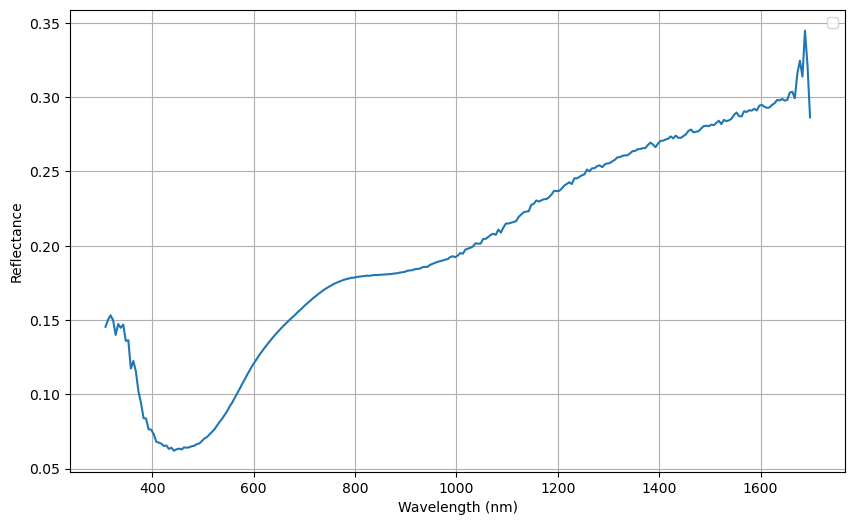

In [3]:
import matplotlib.pyplot as plt
data = pd.read_csv(r"K:\ALL\coen\exp1\combined\rust6_combined.csv")
w = data['wavelength_nm']
ref = data['reflectance']

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.plot(w, ref)
plt.legend()
plt.show()